In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import pandas as pd
import matplotlib.pyplot as plt

from elicit.plotting import func
from elicit.loss_functions import MMD_energy
from elicit.main import prior_elicitation

tfd = tfp.distributions

C:\Users\bockting\AppData\Roaming\Python\Python311\site-packages\bayesflow\trainers.py:27: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


# Quickstart

## The statistical model
Specify your generative model.

\begin{align*}
    \beta_i &\sim \text{Normal}(\mu_i, \sigma_i) \quad \text{for } i=0,1 \\
    \sigma &\sim \text{HalfNormal}(\sigma_2) \\
    \mu &= \boldsymbol{\beta}\mathbf{X} \\
    y_\text{pred} &= \text{Normal}(\mu, \sigma)
\end{align*}

Hyperparameter to-be-learned
$$
\lambda = (\mu_0, \sigma_0, \mu_1, \sigma_1, \sigma_2)
$$

In [2]:
class ModelExample:
    def __call__(self, ground_truth, prior_samples, design_matrix):
        # model parameters
        beta0 = prior_samples[:,:,0][:,:,None]
        beta1 = prior_samples[:,:,1][:,:,None]
        sigma = prior_samples[:,:,-1][:,:,None]
        # linear predictor (= mu)
        epred = beta0+beta1*design_matrix[None,None,:]
        # likelihood
        likelihood = tfd.Normal(loc=epred, scale=sigma)
        # prior predictive distribution
        ypred = likelihood.sample()

        return dict(
            likelihood=likelihood, ypred=ypred, epred=epred,
            prior_samples=prior_samples
        )

### Specify design matrix

+ standardize predictor!

In [3]:
def create_design_matrix(selected_obs_quants, N):
    X = tf.range(1, N, dtype=tf.float32)
    # standardize predictor
    X_std = tf.divide(tf.subtract(X, tf.reduce_mean(X)), tf.math.reduce_std(X))
    # select only specific design points of predictor
    X_std_selected = tfp.stats.percentile(X_std, selected_obs_quants)
    return X_std_selected

design_matrix=create_design_matrix([25, 50, 75], 30)

### Define generative model

In [4]:
generative_model=dict(
    model=ModelExample,
    additional_model_args=dict(
        design_matrix=design_matrix
    )
)

### Specify model parameters

In [5]:
# hyperparameter in the unconstrained space
from elicit.user.custom_functions import Normal_log, HalfNormal_log

halfnormal_log = HalfNormal_log()
normal_log = Normal_log()

model_parameters=dict(
    beta0=dict(
        family=normal_log,
        hyperparams=dict(mean = hp("mu0", lower = 0, class="real" vs. "array" vs. "correlation_matrix", dim=2), sd = "log_sigma0"),
        
    ),
    beta1=dict(
        family=normal_log,
        hyperparams=["mu1", "log_sigma1"]
    ),
    sigma=dict(
        family=halfnormal_log,
        hyperparams=["log_sigma2"]
    )
)

## The expert
### Use an oracle 

\begin{align*}
    \beta_0 &\sim \text{Normal}(5., 2.) \\
    \beta_1 &\sim \text{Normal}(0.5, 0.8) \\
    \sigma &\sim \text{HalfNormal}(10.)
\end{align*}
Thus,
$$
\lambda^*=(5., 2., 0.5, 0.8, 10.)
$$

In [6]:
expert_data=dict(
    data=None,
    from_ground_truth=True,
    simulator_specs = dict(
        beta0=tfd.Normal(5., 2.),
        beta1=tfd.Normal(0.5, 0.8),
        sigma=tfd.HalfNormal(10.)
        ),
    samples_from_prior = 10_000
)

In [ ]:
expert_data= simulated_expert_data(specs, samples=...)
#vs 
expert_data = expert_data

### Elicited information

+ Quantile-based elicitation for ypred yielding in $y_\text{pred} \mid X_{q25}$, $y_\text{pred} \mid X_{q50}$ and $y_\text{pred} \mid X_{q75}$
+ Quantile-based elicitation for $R^2$

In [11]:
def compute_logR2(ypred, epred):
    var_epred = tf.math.reduce_variance(epred, -1)
    # variance of difference between ypred and epred
    var_diff = tf.math.reduce_variance(tf.subtract(ypred, epred), -1)
    var_total = var_epred + var_diff
    # variance of linear predictor divided by total variance
    log_R2 = tf.subtract(tf.math.log(var_epred), tf.math.log(var_total))
    return log_R2

target_quantities=dict(
    ypred=dict(
        elicitation_method="quantiles",
        quantiles_specs=(5, 25, 50, 75, 95),
        loss=MMD_energy,
        loss_weight=1.
    ),
    logR2=dict(
        custom_target_function=dict(
            function=compute_logR2,
            additional_args=None
        ),
        elicitation_method="quantiles",
        quantiles_specs=(5, 25, 50, 75, 95),
        loss=MMD_energy,
        loss_weight=1.
    )
)

## Putting it all together and learn the prior hyperparameters


In [12]:
prior_elicitation(
    model_parameters=model_parameters,
    expert_data=expert_data,
    generative_model=generative_model,
    target_quantities=target_quantities,
    optimization_settings=dict(
        optimizer=tf.keras.optimizers.Adam,
        optimizer_specs=dict(
            learning_rate=0.01, 
            clipnorm=1.0
        )
    ),
    initialization_settings = dict(
        method="random", 
        loss_quantile=0,
        number_of_iterations=10
    ),
    training_settings=dict(
        method="parametric_prior",
        sim_id="example_model",
        seed=0,
        B=128,
        samples_from_prior=200,
        epochs=500,
        output_path="results",
        view_ep=50
    )
)

init_method=random
(0) 3.8 (1) 5.5 (2) 4.1 (3) 2.6 (4) 5.3 (5) 4.1 (6) 5.7 (7) 3.1 (8) 4.6 (9) 3.9  
epoch_time: 0.323 sec
Epoch: 0, loss: 2.54697,                      lr: 0.010000
epoch_time: 0.313 sec
Epoch: 50, loss: 1.90316,                      lr: 0.010000
Estimated time until completion: 00:02:47
epoch_time: 0.313 sec
Epoch: 100, loss: 1.02646,                      lr: 0.010000
Estimated time until completion: 00:02:25
epoch_time: 0.383 sec
Epoch: 150, loss: 0.59139,                      lr: 0.010000
Estimated time until completion: 00:02:03
epoch_time: 0.440 sec
Epoch: 200, loss: 0.35818,                      lr: 0.010000
Estimated time until completion: 00:01:46
epoch_time: 0.411 sec
Epoch: 250, loss: 0.22915,                      lr: 0.010000
Estimated time until completion: 00:01:27
epoch_time: 0.393 sec
Epoch: 300, loss: 0.20542,                      lr: 0.010000
Estimated time until completion: 00:01:09
epoch_time: 0.408 sec
Epoch: 350, loss: 0.20541,                     

## Inspect results

AttributeError: 'Axes' object has no attribute 'xlabel'

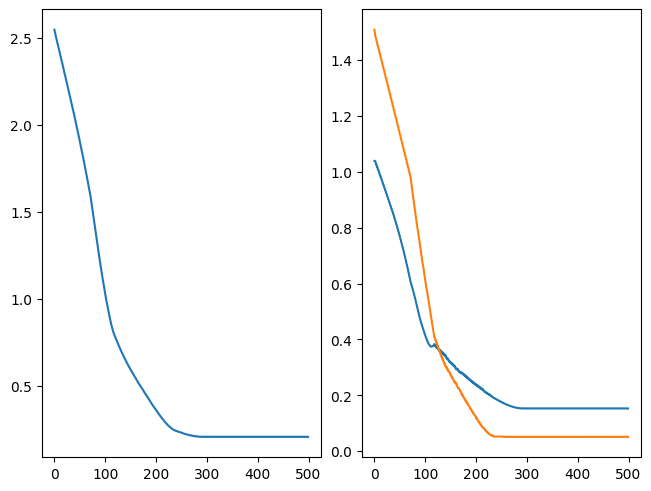

In [14]:
path = "elicit/results/parametric_prior/example_model_0/"

pd.read_pickle(path + "/expert/elicited_statistics.pkl")

# loss function
func.plot_loss(path)

In [16]:
pd.read_pickle(path + "/elicited_statistics.pkl")

{'quantiles_ypred': <tf.Tensor: shape=(128, 5), dtype=float32, numpy=
 array([[-1.40922184e+01,  4.34350491e-01,  4.92502642e+00,
          8.96121979e+00,  2.43081417e+01],
        [-1.16768131e+01,  1.28443384e+00,  5.03073025e+00,
          8.90634441e+00,  2.13240242e+01],
        [-1.18353682e+01,  9.74644661e-01,  5.03020239e+00,
          9.17309189e+00,  2.32363052e+01],
        [-1.32483339e+01,  1.89633536e+00,  5.02199030e+00,
          9.04155636e+00,  2.35339661e+01],
        [-1.18181114e+01,  9.26339149e-01,  4.98266172e+00,
          8.63720322e+00,  2.27122440e+01],
        [-9.92835999e+00,  1.58493900e+00,  5.03793478e+00,
          8.36143398e+00,  1.93368034e+01],
        [-1.23658648e+01,  1.20916915e+00,  5.21361113e+00,
          8.48181152e+00,  2.10963554e+01],
        [-1.19396191e+01,  7.94543743e-01,  4.68009472e+00,
          8.60949326e+00,  2.05611897e+01],
        [-1.28879347e+01,  1.34788966e+00,  5.21771145e+00,
          9.31998062e+00,  2.14068623e

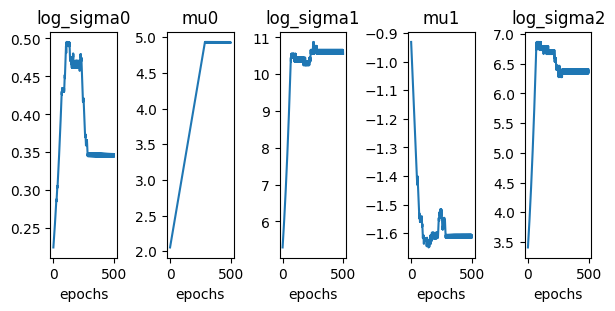

In [99]:
# convergence
func.plot_convergence(path)

<tf.Tensor: shape=(), dtype=float32, numpy=1.4190675>